Namespace(attr_path='data/celeba/list_attr_celeba.txt', batch_size=16, beta1=0.5, beta2=0.999, c2_dim=8, c_dim=3, celeba_crop_size=178, celeba_image_dir='data/celeba/images', d_conv_dim=64, d_lr=0.0001, d_repeat_num=6, dataset='RaFD', g_conv_dim=64, g_lr=0.0001, g_repeat_num=6, image_size=64, lambda_cls=1, lambda_gp=10, lambda_rec=10, log_dir='stargan/logs', log_step=10, lr_update_step=1000, mode='test', model_save_dir='models/emo2Img', model_save_step=10000, n_critic=5, num_iters=200000, num_iters_decay=100000, num_workers=1, rafd_crop_size=256, rafd_image_dir='inp/test', result_dir='res', resume_iters=None, sample_dir='stargan/samples', sample_step=1000, selected_attrs=['neg', 'neu', 'pos'], test_iters=200000, use_tensorboard=True)
Generator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 12

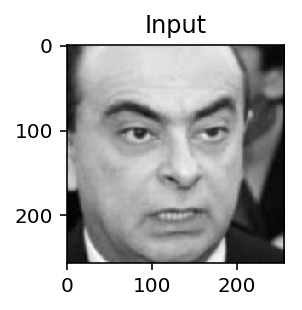

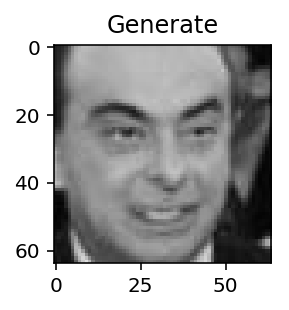

In [4]:
#################
#   テキスト ⇒ 画像生成    #
#################

####テキスト→感情####

import time
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle
from PIL import Image

t1 = time.time() 

MAX_SEQUENCE_LENGTH = 30 # max length of text (words) including padding

with open('src/tec/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
classes = ["neutral", "happy", "sad", "hate","anger"]
    
##入力##    
text = ['Very good!!']
# text = ['Is not it useless?','very good!!', "I don't feel well today.", "A triplet was born."]
img_path = "inp/test/neu/Carlos_Ghosn_0002.jpg"

model = load_model('models/txt2emo/checkpoint-0.923.h5')

sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
pred = y_prob.argmax(axis=-1)[0]

t2 = time.time() 

####感情→画像####
%run -i src/stg/main.py --mode test --dataset RaFD --rafd_crop_size 256 --image_size 64 --c_dim 3 --selected_attrs neg neu pos --rafd_image_dir inp/test --model_save_dir models/emo2Img --result_dir res

####結果表示####
print('')
print("％％％％％％結果％％％％％％")
print("入力文：", text[0],"-->感情推定結果：",classes[pred],"\n")

from PIL import Image
import matplotlib.pyplot as plt

# 元画像
img_inp = Image.open(img_path)
plt.figure(figsize=(3, 2)) # figureの縦横の大きさ
plt.title("Input")
plt.imshow(np.array(img_inp), 'gray')

# 出力画像
img_oup = Image.open("res/1-images.jpg")
imga = np.array(img_oup)
imsize = 64

plt.figure(figsize=(3, 2)) # figureの縦横の大きさ
plt.title("Generate")

if pred == 0: # neutral
    st = imsize*2
    plt.imshow(imga[:, st:st+imsize])
elif pred == 1: # happy
    st = imsize*3
    plt.imshow(imga[:, st:st+imsize])
else: # sad, hate, anger
    st = imsize
    plt.imshow(imga[:, st:st+imsize])
    
t3 = time.time() 
t_t2e = t2-t1
t_e2i = t3-t2
t_tot = t3-t1

print(f"経過時間(text⇒emo)：{t_t2e}")
print(f"経過時間(emo⇒img)：{t_e2i}")
print(f"経過時間(total)：{t_tot}")
